# Inferencing MNIST ONNX Model using AI-Serving

The MNIST handwritten digit classification problem is a classic dataset used in computer vision and deep learning, and Convolutional Neural Network (CNN) is the current state-of-art architecture for image classification task.

In this tutorial, we will use the Open Neural Network eXchange (ONNX) format to show how to deploy a pre-trained MNIST CNN model using AI-Serving.

## Install dependencies
We will install python libraries for data manipulation, image manipulation and display:

In [ ]:
!pip install numpy
!pip install matplotlib

## Prerequisites to run the notebook

1. Download the pre-trained MNIST ONNX model file (mnist.tar.gz) from [here](https://onnxzoo.blob.core.windows.net/models/opset_8/mnist/mnist.tar.gz). For example, you could use `wget` and `tar` to download and uncompress the tar file.  Please, refer to [MNIST - Handwritten Digit Recognition](https://github.com/onnx/models/tree/master/vision/classification/mnist) for details about the MNIST CNN model. 

```bash
wget https://onnxzoo.blob.core.windows.net/models/opset_8/mnist/mnist.tar.gz
tar xvzf mnist.tar.gz
```
   
2. Pull the latest docker image of AI-Serving with ONNX that leverages the CPU version of [ONNX Runtime](https://github.com/microsoft/onnxruntime). Please, refer to [Docker Containers for AI-Serving](https://github.com/autodeployai/ai-serving/tree/master/dockerfiles) about more docker images.

```bash
docker pull autodeployai/ai-serving
```
   
3. Start a docker container of AI-Serving. The port `9090` is the port of HTTP endpoint while `9091` is for gRPC, you could see an error likes `Bind for 0.0.0.0:9090 failed: port is already allocated`, please use another new port instead of the first part as follows `-p $(NEW_PORT):9090` to run the command again, and remeber the port is always needed in the URL of HTTP endpoint. 

```bash
docker run --rm -it -v $(PWD):/opt/ai-serving -p 9090:9090 -p 9091:9091 autodeployai/ai-serving
```

## Additional information about two python files
In the current directory, there are two python files `onnx_ml_pb2.py` and `ai_serving_pb2.py`, which are generated from compiling the [two proto files](https://github.com/autodeployai/ai-serving/tree/master/src/main/protobuf) using [protoc](https://developers.google.com/protocol-buffers/docs/pythontutorial), for example, the command as follows:

```bash
protoc -I=$SRC_DIR --python_out=. ai-serving.proto onnx-ml.proto
```

## Import dependency libraries

In [1]:
from os import path
import numpy as np
import requests
from matplotlib import pyplot as plt
from pprint import pprint

import onnx_ml_pb2
import ai_serving_pb2

## Define the base HTTP URL

In [2]:
# Change the port number 9090 to the appropriate port number 
# if you had changed it during AI-Serving docker instantiation
port = 9090
base_url = 'http://localhost:' + str(port)

## Test the server whether available
Use the specific endpoint `http://host:port/up` to test whether the server has been initialized and is ready to accept requests. The `OK` message indicates it's available.

In [3]:
test_url = base_url + '/up'
response = requests.get(test_url)
print('The server status message: ', response.text)

The server status message:  OK


## Deploy the model `mnist/model.onnx` into AI-Serving
First, we need to deploy the MNIST ONNX model into AI-Serving, which can serve multiple models, or multiple versions for a named model at once. 

In [4]:
# The specified servable name
model_name = 'mnist'
deployment_url = base_url + '/v1/models/' + model_name

# The content type could be one of those three options for ONNX models.
# 1. application/octet-stream, 
# 2. application/vnd.google.protobuf
# 3. application/x-protobuf
headers = {'Content-Type': 'application/x-protobuf'}

model_path = path.join('mnist', 'model.onnx')
with open(model_path, 'rb') as file:
    deployment_response = requests.put(deployment_url, headers=headers, data=file)

# The response is a JSON object contains the sepcified servable name and the model version deployed
model_deployed_info = deployment_response.json()
print('Model deployed info: ', model_deployed_info)

Model deployed info:  {'name': 'mnist', 'version': 1}


## Get metadata of the deployed model
The metadata will contain model input and output fields info, which is needed when constructing an input request and consume an output response.

In [5]:
model_version = model_deployed_info['version']
metadata_url = base_url + '/v1/models/' + model_name + '/versions/' + str(model_version)
metadata_response = requests.get(metadata_url)

print('The model metadata info:')
pprint(metadata_response.json())

The model metadata info:
{'createdAt': '2020-04-23T07:00:41',
 'id': '81009106-041d-4481-8b8b-92f9097e0cb4',
 'latestVersion': 1,
 'name': 'mnist',
 'updateAt': '2020-04-23T07:00:41',
 'versions': [{'createdAt': '2020-04-23T07:00:41',
               'hash': 'd7cd24a0a76cd492f31065301d468c3d',
               'outputs': [{'name': 'Plus214_Output_0',
                            'shape': [1, 10],
                            'type': 'tensor(float)'}],
               'predictors': [{'name': 'Input3',
                               'shape': [1, 1, 28, 28],
                               'type': 'tensor(float)'}],
               'runtime': 'ONNX Runtime',
               'serialization': 'onnx',
               'size': 26454,
               'type': 'ONNX',
               'version': 1}]}


## Load the input images
We will use the sample test data in the compressed file `mnist.tar.gz`, there are 3 test cases that include both input and output data.

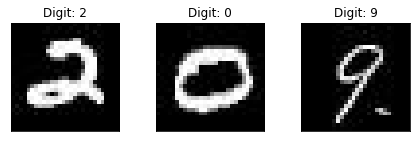

In [6]:
input_tensors = []
input_arrays = []
output_tensors = []
output_arrays = []
output_digits = []

def postprocess(result):
    """postprocess the predicted results"""
    return int(np.argmax(np.array(result).squeeze(), axis=0))

# Read the three test data sets and show them.
fig = plt.figure()
model_dir = 'mnist'
for i in range(3):
    input_test_data_set = path.join(model_dir, 'test_data_set_{0}'.format(i), 'input_0.pb')
    output_test_data_set = path.join(model_dir, 'test_data_set_{0}'.format(i), 'output_0.pb')
    
    # Read the input data
    input_tensor = onnx_ml_pb2.TensorProto()
    with open(input_test_data_set, 'rb') as f:
        input_tensor.ParseFromString(f.read())
    input_tensors.append(input_tensor)
    input_tensor_array = np.frombuffer(input_tensor.raw_data, dtype=np.float32).astype('float32')
    input_arrays.append(input_tensor_array)
    
    # Read the output data
    output_tensor = onnx_ml_pb2.TensorProto()
    with open(output_test_data_set, 'rb') as f:
        output_tensor.ParseFromString(f.read())
    output_tensors.append(output_tensor)
    output_tensor_array = np.frombuffer(output_tensor.raw_data, dtype=np.float32).astype('float32')
    output_arrays.append(output_tensor_array)
    output_digit = postprocess(output_tensor_array)
    output_digits.append(output_digit)
    
    # Add a subplot for the current digit.
    plt.subplot(1, 3, i+1)
    plt.tight_layout()
    plt.imshow(input_tensor_array.reshape([28, 28]), cmap='gray', interpolation='none')
    plt.title("Digit: {}".format(output_digit))
    plt.xticks([])
    plt.yticks([])
plt.show()

## HTTP request formats for the AI-Serving
The request for AI-Serving could have two formats: JSON and binary, the HTTP header Content-Type tells the server which format to handle and thus it is required for all requests. The binary payload has better latency, especially for the big tensor value for ONNX models, while the JSON format is easy for human readability.

- Content-Type: application/octet-stream, application/vnd.google.protobuf or application/x-protobuf. The request body must be the protobuf message PredictRequest, besides of those common scalar values, it can use the standard TensorProto value directly.


- Content-Type: application/json. The request body must be a JSON object formatted as described [here](https://github.com/autodeployai/ai-serving#4-predict-api).

## Construct the binary requests for the AI-Serving
Create both instances of PredictRequest, one is using the `Records` format that has one case, the other is using the `Split` that contains two cases.

In [7]:
from ai_serving_pb2 import RecordSpec, Record, PredictRequest, ListValue, Value

# Create an instance of RecordSpec with records that contains only the first tensor.
request_message_records = PredictRequest(X=RecordSpec(
    records=[Record(fields={'Input3': Value(tensor_value=input_tensors[0])})]
))

# Create an instance of RecordSpec with columns and data that contains the last two tensors.
request_message_split = PredictRequest(X=RecordSpec(
    columns = ['Input3'],
    data = [
        ListValue(values=[Value(tensor_value=input_tensors[1])]),
        ListValue(values=[Value(tensor_value=input_tensors[2])])
    ]
))

## Make the HTTP requests with binary data to the AI-Serving
Make predictions using the AI-Serving, the content type of requests with binary data must be one of those three candidates.

In [8]:
headers = {'Content-Type': 'application/x-protobuf'}

# When version is omitted, the latest version is used.
prediction_url = base_url + '/v1/models/' + model_name

# Make prediction for the `records` request message.
prediction_response_records = requests.post(prediction_url, 
                                           headers=headers, 
                                           data=request_message_records.SerializeToString())

# Make prediciton for the `split` request message.
prediction_response_split = requests.post(prediction_url, 
                                           headers=headers, 
                                           data=request_message_split.SerializeToString())

## Consume the HTTP response with binary data from the AI-serving
Having received the results from the server, we are going to parse the "serialized" message that we just received for us to make sense of the results. And compare the actual results to the desired ones. 

**NOTE: The data format of the output response is always the same as the input request.**

In [9]:
def print_output_and_compare_result(index, output_tensor):
    # Print the actual result for the tensor
    actual_output_tensor_array = np.asarray(output_tensor.float_data, dtype=np.dtype('float32'))
    print('Actual output shape of test data set {}: '.format(index), output_tensor.dims)
    print('Actual output values of test data set {}: '.format(index), actual_output_tensor_array)
    print('Actual final recognized digit of test data set {}: '.format(index), postprocess(actual_output_tensor_array))
    
    # Both results are expected be equal to each other.
    np.testing.assert_almost_equal(actual_output_tensor_array, output_arrays[index], 1)
    np.testing.assert_equal(postprocess(actual_output_tensor_array), output_digits[index])


# Parse the response message from the `recrods` request.
response_message = ai_serving_pb2.PredictResponse()
response_message.ParseFromString(prediction_response_records.content)

# Print and compare the result for the test data set 0
print_output_and_compare_result(0, response_message.result.records[0].fields['Plus214_Output_0'].tensor_value)
print('\n----------------------------------------------------------------------------\n')

# Parse the response message from the `split` requesgt.
response_message = ai_serving_pb2.PredictResponse()
response_message.ParseFromString(prediction_response_split.content)

print('Acutal output columns: ', response_message.result.columns)
print('\n----------------------------------------------------------------------------\n')

# Print and compare the result for the test data set 1
print_output_and_compare_result(1, response_message.result.data[0].values[0].tensor_value)

print('\n----------------------------------------------------------------------------\n')

# Print and compare the result for the test data set 2
print_output_and_compare_result(2, response_message.result.data[1].values[0].tensor_value)

Actual output shape of test data set 0:  [1, 10]
Actual output values of test data set 0:  [  975.67035   -618.7242    6574.5654     668.0283    -917.27106
 -1671.6361   -1952.7599     -61.549576  -777.17645  -1439.5316  ]
Actual final recognized digit of test data set 0:  2

----------------------------------------------------------------------------

Acutal output columns:  ['Plus214_Output_0']

----------------------------------------------------------------------------

Actual output shape of test data set 1:  [1, 10]
Actual output values of test data set 1:  [ 5041.8896   -3568.8784    -187.82423  -1685.797    -1183.3229
  -614.4292     892.66406   -373.659     -290.26212   -111.176254]
Actual final recognized digit of test data set 1:  0

----------------------------------------------------------------------------

Actual output shape of test data set 2:  [1, 10]
Actual output values of test data set 2:  [-2334.0884   -1113.6252    1076.5806    -860.2392    1588.5349
 -1534.3469 

## Construct JSON requests for the AI-Serving
Create both JSON objects, one is using the `Records` format that has one case, the other is using `Split` that contains two cases.

In [10]:
# Create a JSON object with records that contains only the first tensor.
request_json_recoreds = {
    'X': [{
        'Input3': input_arrays[0].tolist()
    }]
}

# Create a JSON object with columns and data that contains the last two tensors.
request_json_split = {
    'X': {
        'columns': ['Input3'],
        'data': [[input_arrays[1].tolist()], [input_arrays[2].tolist()]]
    }
}

## Make the HTTP requests with JSON data to the AI-Serving
Make predictions using the AI-Serving, the content type of requests with JSON data must be `application/json`.

In [11]:
# When version is omitted, the latest version is used.
prediction_url = base_url + '/v1/models/' + model_name

# The Content-Type: application/json is specified implicitly when using json instead of data
prediction_json_response_records = requests.post(prediction_url, json=request_json_recoreds)
prediction_json_response_split = requests.post(prediction_url, json=request_json_split)

## Consume the HTTP response with JSON data from the AI-serving
Having received the results from the server, we are going to parse the JSON text that we just received for us to make sense of the results. And compare the actual results to the desired ones.

**NOTE: The data format of the output response is always the same as the input request.**

In [12]:
def print_json_output_and_compare_result(index, output_list):
    # Print the actual result for the tensor
    actual_output_tensor_array = np.asarray(output_list, dtype=np.dtype('float32')).reshape(output_arrays[index].shape)
    print('Actual output shape of test data set {}: '.format(index), actual_output_tensor_array.shape)
    print('Actual output values of test data set {}: '.format(index), actual_output_tensor_array)
    print('Actual final recognized digit of test data set {}: '.format(index), postprocess(actual_output_tensor_array))
    
    # Both results are expected be equal to each other.
    np.testing.assert_almost_equal(actual_output_tensor_array, output_arrays[index], 1)
    np.testing.assert_equal(postprocess(actual_output_tensor_array), output_digits[index])


# Parse the response json from the `recrods` request.
response_json = prediction_json_response_records.json()
print('The response json from the `records` request:')
pprint(response_json)
print('\n----------------------------------------------------------------------------\n')

# Print and compare the result for the test data set 0
print_json_output_and_compare_result(0, response_json['result'][0]['Plus214_Output_0'])
print('\n----------------------------------------------------------------------------\n')

# Parse the response json from the `split` requesgt.
response_json = prediction_json_response_split.json()
print('The response json from the `split` request:')
pprint(response_json)
print('\n----------------------------------------------------------------------------\n')

# Print and compare the result for the test data set 1
print_json_output_and_compare_result(1, response_json['result']['data'][0])

print('\n----------------------------------------------------------------------------\n')

# Print and compare the result for the test data set 2
print_json_output_and_compare_result(2, response_json['result']['data'][1])


The response json from the `records` request:
{'result': [{'Plus214_Output_0': [[975.6703491210938,
                                   -618.7241821289062,
                                   6574.5654296875,
                                   668.0283203125,
                                   -917.2710571289062,
                                   -1671.6361083984375,
                                   -1952.7598876953125,
                                   -61.54957580566406,
                                   -777.1764526367188,
                                   -1439.5316162109375]]}]}

----------------------------------------------------------------------------

Actual output shape of test data set 0:  (10,)
Actual output values of test data set 0:  [  975.67035   -618.7242    6574.5654     668.0283    -917.27106
 -1671.6361   -1952.7599     -61.549576  -777.17645  -1439.5316  ]
Actual final recognized digit of test data set 0:  2

---------------------------------------------------